In [1]:
import requests
import pandas as pd
import numpy as np 
from pyarrow import fs
import pyarrow as pa
import pyarrow.parquet as pq
from scipy.stats import zscore
import matplotlib.pyplot as plt
from tqdm import tqdm
from helpers import *
pd.set_option('display.float_format', '{:.2f}'.format)


Data extraction from multiples files : API SNCF, API GOUV, economic regional data from web csv
first use sncf well established api to access data of stations 

In [2]:
station_geo_data = get_names_geo_data_from_sncf_api(
    endpoint_suffix="gares-de-voyageurs",
    select="""nom as nom_gare,
                           position_geographique,
                           codes_uic as uic""",
)

station_freq_data = get_names_geo_data_from_sncf_api(
    endpoint_suffix="frequentation-gares",
    select="""total_voyageurs_2022,
                           code_postal,
                           nom_gare,
                           code_uic_complet as uic """,
)

nb of stations downloaded: 2881, from table gares-de-voyageurs
nb of stations downloaded: 3010, from table frequentation-gares


In [3]:
station_geo_data=station_geo_data.rename(columns={'position_geographique.lon': 'lon_gare', 'position_geographique.lat': 'lat_gare'})
station_geo_data=station_geo_data.drop("position_geographique",axis=1)

In [4]:
merged=station_freq_data.merge(station_geo_data.drop("nom_gare",axis=1),on=["uic"],how="left")
merged=merged[merged["total_voyageurs_2022"]>0]


In [7]:
merged=get_absent_lat_lon_from_gouv_api(merged)
merged.isna().sum()

94 absent addresses filled successfully


total_voyageurs_2022    0
code_postal             0
nom_gare                0
uic                     0
lon_gare                0
lat_gare                0
dtype: int64

here insert code from communes and delete extract from S3!!!!!!!!!!!!!

get stat about regions

In [8]:

regional_stat=s3.get_tables_from_s3("clichere/diffusion/rev_dip_pop_comm.parquet")

In [9]:
regional_stat=regional_stat[(regional_stat["pop2022"]>0) & (regional_stat["revmoy2022"]>0) & (regional_stat["pbac2022"].notna())   ]

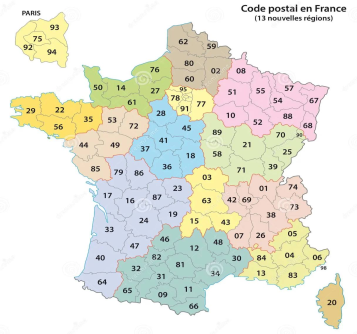

In [10]:
regional_stat=fill_regional_stat_with_lat_lon(regional_stat)

Processing: 34711it [37:30, 15.42it/s]


In [11]:
regional_stat.sample(2)

,codecommune,nomcommune,pop2022,revmoy2022,pbac2022,psup2022,lon,lat
17090,44106,MOUTIERS-EN-RETZ,1868,21421.68,0.40,0.21,-2.00,47.06
638,02224,COURCELLES-SUR-VESLE,370,13772.33,0.00,0.00,3.57,49.34


In [12]:
fusion=merged.merge(regional_stat,left_on="code_postal",right_on="codecommune",how="left")

In [13]:
fusion.sample(2)

,total_voyageurs_2022,code_postal,nom_gare,uic,lon_gare,lat_gare,codecommune,nomcommune,pop2022,revmoy2022,pbac2022,psup2022,lon,lat
1007,110387,80133,Noyelles-sur-Mer,87317396,1.70,50.19,80133,BRAILLY-CORNEHOTTE,285.00,12382.98,0.37,0.06,1.96,50.22
2494,422514,91520,Égly,87545475,2.22,48.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
fusion.isna().sum()

total_voyageurs_2022       0
code_postal                0
nom_gare                   0
uic                        0
lon_gare                   0
lat_gare                   0
codecommune             1482
nomcommune              1482
pop2022                 1482
revmoy2022              1482
pbac2022                1482
psup2022                1482
lon                     1484
lat                     1484
dtype: int64

In [15]:
no_math=fusion[fusion["codecommune"].isna()]
yes_math=fusion[fusion["codecommune"].notna()]

In [16]:
crossed=no_math[["uic","lon_gare","lat_gare"]].merge(regional_stat[["codecommune","nomcommune","lon","lat"]],how="cross")

In [17]:
crossed.sample(2)

,uic,lon_gare,lat_gare,codecommune,nomcommune,lon,lat
25509131,87765826,4.92,44.01,80397,GUEUDECOURT,2.84,50.06
33942009,87592105,1.65,45.76,76225,ECRETTEVILLE-LES-BAONS,0.67,49.63


In [18]:

crossed["distance_km"] = haversine_vectorized(crossed["lat_gare"], crossed["lon_gare"], crossed["lat"], crossed["lon"])




In [19]:
idx = crossed.groupby(['uic'])['distance_km'].idxmin()

# Select rows corresponding to the minimal distances
result = crossed.loc[idx].reset_index(drop=True)

In [20]:
no_math_filled=result.merge(merged[["total_voyageurs_2022","code_postal","nom_gare","uic"]],on=["uic"],how="left").merge(regional_stat[["codecommune"	,	"pop2022",	"revmoy2022",	"pbac2022",	"psup2022"]],on=["codecommune"],how="left")

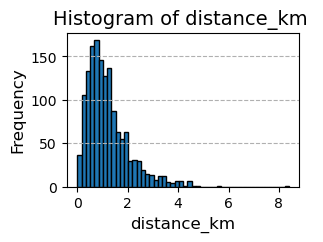

In [21]:
plot_hist((no_math_filled["distance_km"]))

In [22]:
no_math_filled=no_math_filled.drop("distance_km",axis=1)

In [23]:
yes_math=yes_math.reset_index(drop=True)

In [25]:
final=pd.concat([yes_math,no_math_filled[yes_math.columns]],axis=0)

In [32]:
final=final[final["lon"].notna()].drop(["lon","lat"],axis=1)


In [33]:
final.shape

(2938, 12)

In [34]:
final

,total_voyageurs_2022,code_postal,nom_gare,uic,lon_gare,lat_gare,codecommune,nomcommune,pop2022,revmoy2022,pbac2022,psup2022
0,40825,44170,Abbaretz,87481614,-1.52,47.55,44170,ST-JULIEN-DE-VOUVANTES,1017.00,12806.55,0.32,0.16
1,80648,62121,Achiet-le-Grand,87342048,2.78,50.13,62121,BEUGNATRE,243.00,8432.39,0.53,0.13
2,11325,30220,Aigues-Mortes,87775858,4.19,43.57,30220,ROQUEDUR,312.00,7633.23,0.67,0.42
3,128969,80250,Ailly-sur-Noye,87313221,2.36,49.75,80250,DOMVAST,365.00,14541.22,0.54,0.38
4,126465,73210,Aime - La Plagne,87741769,6.65,45.55,73210,PUYGROS,417.00,17936.02,0.61,0.47
...,...,...,...,...,...,...,...,...,...,...,...,...
1477,122,66760,Ur - Les Escaldes,87784884,1.94,42.46,66218,UR,311.00,18354.76,0.34,0.34
1478,86,66760,Bena Fanes,87784892,1.92,42.46,66066,ENVEITG,663.00,14575.08,0.49,0.46
1479,71860,66290,Cerbère,87785006,3.16,42.44,66048,CERBERE,1266.00,14498.83,0.36,0.16
1480,623710,93140,Remise à Jorelle,87988709,2.49,48.89,93010,BONDY,53353.00,12882.64,0.43,0.24


In [35]:
s3.from_pandas_to_parquet_store_in_s3(final,"aayrapetyan/final_table.parquet")

In [36]:
s3.get_tables_from_s3("aayrapetyan/final_table.parquet")

,total_voyageurs_2022,code_postal,nom_gare,uic,lon_gare,lat_gare,codecommune,nomcommune,pop2022,revmoy2022,pbac2022,psup2022
0,40825,44170,Abbaretz,87481614,-1.52,47.55,44170,ST-JULIEN-DE-VOUVANTES,1017.00,12806.55,0.32,0.16
1,80648,62121,Achiet-le-Grand,87342048,2.78,50.13,62121,BEUGNATRE,243.00,8432.39,0.53,0.13
2,11325,30220,Aigues-Mortes,87775858,4.19,43.57,30220,ROQUEDUR,312.00,7633.23,0.67,0.42
3,128969,80250,Ailly-sur-Noye,87313221,2.36,49.75,80250,DOMVAST,365.00,14541.22,0.54,0.38
4,126465,73210,Aime - La Plagne,87741769,6.65,45.55,73210,PUYGROS,417.00,17936.02,0.61,0.47
...,...,...,...,...,...,...,...,...,...,...,...,...
1477,122,66760,Ur - Les Escaldes,87784884,1.94,42.46,66218,UR,311.00,18354.76,0.34,0.34
1478,86,66760,Bena Fanes,87784892,1.92,42.46,66066,ENVEITG,663.00,14575.08,0.49,0.46
1479,71860,66290,Cerbère,87785006,3.16,42.44,66048,CERBERE,1266.00,14498.83,0.36,0.16
1480,623710,93140,Remise à Jorelle,87988709,2.49,48.89,93010,BONDY,53353.00,12882.64,0.43,0.24
